### Model 300 basicStVs

Charlie Shobe, borrowing heavily from Greg Tucker's notes

This notebook is a test of stream power driven by stochastic hydrology with variable source area.

Fluvial erosion in this model is described by:
$$ E = F_w K_q r^{1/2} A_{eff}^{1/2} S$$,

where $r = p - I_c (1 - \exp ( -p / I_c ))$, $p$ is the precipitation rate, $F_w$ is the fraction of wet days, $K_q$ is an erosion coefficient, and $I_c$ is inflitration capacity.

THIS MODEL INCLUDES VARIABLE SOURCE AREA HYDROLOGY, so:
$$A_{eff} = A e^{( -\alpha S / A)} = A R_r$$.
It also has linear hillslope diffusion:
$$\frac{d\eta}{dt} = -D\nabla^2\eta$$

This is a test of the variable source area component. So, at steady state, the landscape will  fall ABOVE the line described by the basic stream power rule.

Because this has VSA hydrology, I can't just turn off the hillslopes. So what we do for a steady-state test is to include hillslope diffusion and show that the topographic slope-area data fall ABOVE the line predicted for stochastic detachment-limited erosion.

The detachment-limited slope-area relationship is

$$S=\left(\frac{U}{K}\right)^{1/n}A^{-m/n}$$

where $K$ is complicated and found by numerical integration across the precip distribution, below



We can see from the above that $K'=K_q(p - I_c (1 - \exp ( -p / I_c )))^m$, where $K'$ omits the factor $F_w$. This whole situation isn't great because $K$ is a function of precipitation rate. To compare this model to an analytical slope-area solution, we need to get a long-term average $K$, which we can do by integrating $K(p)$ over the full probability distribution (Weibull) of $p$:

$$ f(p) = \frac{c}{\lambda}\left( \frac{p}{\lambda} \right)^{(c-1)} e^{-(p/\lambda)^c} $$

to yield an effective $K$:

$$ K = F_w \int_{I_c}^\infty K'(p) f(p) dp  $$

$$ K = F_w \int_{I_c}^\infty K_q (p - I_c (1 - \exp ( -p / I_c )))^m \frac{c}{\lambda}\left( \frac{p}{\lambda} \right)^{(c-1)} e^{-(p/\lambda)^c} dp $$

This must be integrated numerically.

In [1]:
from terrainbento import BasicStVs
import numpy as np
import matplotlib.pyplot as plt
from landlab import imshow_grid
import scipy.special as sp

//anaconda/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
#parameter dictionary 
params = { 'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0,
          'east_boundary_closed' : False,
          'north_boundary_closed' : False,
          'west_boundary_closed' : False,
          'south_boundary_closed' : False,
          'dt' : 10.0,
          'K_stochastic_sp' : 0.005,
          'm_sp' : 0.5,
          'n_sp' : 1.0,
          'linear_diffusivity' : 0.01,
          'outlet_lowering_rate' : 0.0005,
          'output_filename': 'model_000_output',
          'opt_stochastic_duration': False,
          'mean_storm__intensity' : 3.0,
          'intermittency_factor' : .5,
          'infiltration_capacity' : 10,
          'number_of_sub_time_steps' : 10,
          'precip_shape_factor' : 0.7,
          'random_seed' : 1234567,
          'recharge_rate': 0.01,
          'initial_soil_thickness' : 3.0,
          'K_hydraulic_conductivity' : 5000.
} #ksat 15 in examples, recharge rate = 0.01
#ksat=300 is on the extreme high end of the parameter range

In [3]:
#instantiate and establish topo error tolerance
st = BasicStVs(params=params)
tolerance = 0.0001

In [4]:
#time loop
dt = 10
elapsed_time = 0 #years
keep_running = True
while keep_running == True:
    pre_topo = st.grid.at_node['topographic__elevation'][st.grid.core_nodes]
    st.run_one_step(dt)
    post_topo = st.grid.at_node['topographic__elevation'][st.grid.core_nodes]
    if elapsed_time % 1000 == 0:
        print(elapsed_time)
        print('MAX: ', max(abs(pre_topo - post_topo)))
        print('MEAN: ', np.average(abs(pre_topo - post_topo)))
    elapsed_time += dt
    if max(abs(pre_topo - post_topo)) <= tolerance: #1mm
        keep_running = False

0
MAX:  0.216883707608
MEAN:  0.00376401242441
1000
MAX:  0.0059026551533
MEAN:  0.00381256825658
2000
MAX:  0.0165772580323
MEAN:  0.00157405688879
3000
MAX:  0.0172886355432
MEAN:  0.000865255175334
4000
MAX:  0.0193498458767
MEAN:  0.000992320445035
5000
MAX:  0.0121108025966
MEAN:  0.000821956538121
6000
MAX:  0.0235063020309
MEAN:  0.00114718126658
7000
MAX:  0.00413152914208
MEAN:  0.00182350297254
8000
MAX:  0.0111263343433
MEAN:  0.00223010352265
9000
MAX:  0.0057798136511
MEAN:  0.00046862969545
10000
MAX:  0.00525448191227
MEAN:  0.00296600912257
11000
MAX:  0.0049836108383
MEAN:  0.00280650780675
12000
MAX:  0.00391558389833
MEAN:  0.00166091407812
13000
MAX:  0.00839049660269
MEAN:  0.00123045115234
14000
MAX:  0.00345952369961
MEAN:  0.00188129874501
15000
MAX:  0.00580123404549
MEAN:  0.000608830704223
16000
MAX:  0.00360734956749
MEAN:  0.00194924961752
17000
MAX:  0.00478964031099
MEAN:  0.00057544034656
18000
MAX:  0.0101515171585
MEAN:  0.00217038858451
19000
MAX:  0.

KeyboardInterrupt: 

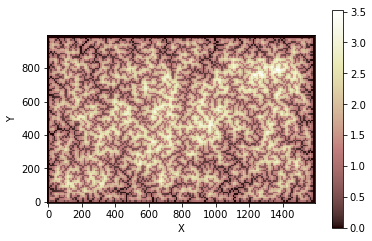

In [5]:
%matplotlib inline
imshow_grid(st.grid, 'topographic__elevation')

(0.0001, 0.05)

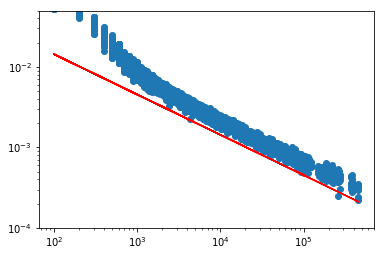

In [6]:
#first: the data
plt.scatter(st.grid.at_node['drainage_area'][(st.grid.node_x > 20)&(st.grid.node_x < 1580)&(st.grid.node_y >20)&(st.grid.node_y<980)], st.grid.at_node['topographic__steepest_slope'][(st.grid.node_x > 20)&(st.grid.node_x < 1580)&(st.grid.node_y >20)&(st.grid.node_y<980)])

#second: the detachment-limited slope-area relationship
plt.plot(st.grid.at_node['drainage_area'][st.grid.core_nodes], (0.0005 / 0.003487) *np.power(st.grid.at_node['drainage_area'][st.grid.core_nodes],-0.5), c='r')

plt.xscale('log')
plt.yscale('log')
plt.ylim(0.0001, 0.05)

In [7]:
##here, try my hand at numerically integrating for effective K
#I am integrating over the probability distribution of precip.

#define parameters:
F_w = 0.5 #intermittency factor
I_c = 0. #infiltration capacity; forms lower bound of integral
K_q = 0.005 #k_stochastic_sp
m = 0.5 #area/discharge exponent
c = 0.7 #precip weibull distribution shape factor
mean_int = 3.0 #mean storm intensity
dp = .1 #interval of precip for numerical integration
upper_bound_p = 100000. #upper boundary on precip for numerical integration

#calculate weibull 'lambda' scale factor using c and mean storm intensity:
#lamda = mean_int / scipy.special.gamma(1+(1/c))
lam = mean_int / sp.gamma(1 + (1 / c))

#now do the numerical integration
summation = 0
sum_over = np.arange(dp, upper_bound_p, dp)
for p in sum_over:
    everything_except_exp = K_q * np.power(p - I_c * (1-np.exp(-p/I_c)), m) * (c / lam) * np.power(p / lam, c-1)
    the_exp = np.exp(-np.power(p / lam, c))
    guts = everything_except_exp * the_exp
    summation += (guts * dp)
#finally, multiply the integral by F_w
k_avg = F_w * summation
print(k_avg)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in double_scalars


0.00348735023038


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in power


(0.0001, 1000)

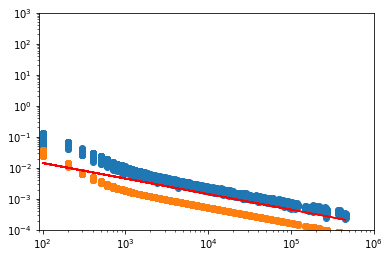

In [8]:
#THREE-PART PLOT WITH DL ANALYTICAL, TOPO DATA, AND SLOPE PREDICTED BY AEFF
#first: the data
plt.scatter(st.grid.at_node['drainage_area'][(st.grid.node_x > 20)&(st.grid.node_x < 1580)&(st.grid.node_y >20)&(st.grid.node_y<980)], st.grid.at_node['topographic__steepest_slope'][(st.grid.node_x > 20)&(st.grid.node_x < 1580)&(st.grid.node_y >20)&(st.grid.node_y<980)])

#second: the detachment-limited slope-area relationship
plt.plot(st.grid.at_node['drainage_area'][st.grid.core_nodes], (0.0005 / 0.00348735) *np.power(st.grid.at_node['drainage_area'][st.grid.core_nodes],-0.5), c='r')

#third: calculate the slope predicted by Aeff
slope_by_aeff = (0.0005 / 0.003487) * np.power((st.rain_rate * st.area) - st.qss, -0.5)
#print len(slope_by_aeff[vs.grid.at_node['drainage_area'][vs.grid.core_nodes]<=1000])
#print len((0.0005 / 0.005) *np.power(vs.grid.at_node['drainage_area'][vs.grid.core_nodes],-0.5)[vs.grid.at_node['drainage_area'][vs.grid.core_nodes]<=1000])

#print slope_by_aeff[vs.grid.at_node['drainage_area'][vs.grid.core_nodes]<=1000]# /( (0.0005 / 0.005) *np.power(vs.grid.at_node['drainage_area'][vs.grid.core_nodes],-0.5)[vs.grid.at_node['drainage_area'][vs.grid.core_nodes]<=1000])


#plt.scatter(vs.eff_area[vs.grid.core_nodes], slope_by_aeff)

plt.scatter(st.grid.at_node['drainage_area'][(st.grid.node_x > 20)&(st.grid.node_x < 1580)&(st.grid.node_y >20)&(st.grid.node_y<980)], slope_by_aeff[(st.grid.node_x > 20)&(st.grid.node_x < 1580)&(st.grid.node_y >20)&(st.grid.node_y<980)])

plt.xscale('log')
plt.yscale('log')
plt.xlim(90, 1000000)
plt.ylim(0.0001, 1000)

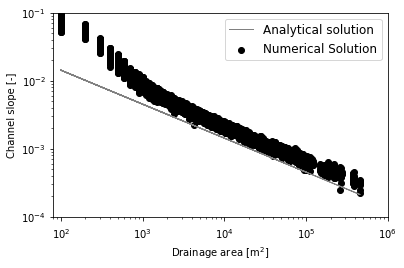

In [9]:
###MAKE SLOPE-AREA PLOT

import matplotlib

#assign area_array and slope_array
area_array = st.grid.at_node['drainage_area'][(st.grid.node_x > 10)&(st.grid.node_x < 1580)&(st.grid.node_y >10)&(st.grid.node_y<980)]
slope_array = st.grid.at_node['topographic__steepest_slope'][(st.grid.node_x > 10)&(st.grid.node_x < 1580)&(st.grid.node_y >10)&(st.grid.node_y<980)]

##instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

#plotting param
matplotlib.rcParams.update({'font.size': 20})

#create an array for the detachment-limited analytical solution
u = 0.0005 #m/yr, uplift or baselevel lowering rate
k = k_avg #fluvial erodibility
m = 0.5 #discharge exponent
n = 1.0 #slope exponent

#calculate analytical slope from area field
analytical_slope_array = np.power((u / k), 1 / n) * np.power(area_array, -m/n)

#plot the slope predicted by the effective area
#slope_by_aeff = (0.0005 / 0.001) * np.power(st.eff_area, -0.5)
#plt.scatter(vs.grid.at_node['drainage_area'][(vs.grid.node_x > 10)&(vs.grid.node_x < 1580)&(vs.grid.node_y >10)&(vs.grid.node_y<980)], 
#            slope_by_aeff[(vs.grid.node_x > 10)&(vs.grid.node_x < 1580)&(vs.grid.node_y >10)&(vs.grid.node_y<980)],
#           label = 'Numerical solution',
#           marker='o', edgecolor='0', color='1')

#plot the data
slope_area.scatter(area_array, slope_array, marker='o', c='k', 
                   label = 'Numerical Solution') #plot HA data


#plot the analytical solution
slope_area.plot(area_array, analytical_slope_array, linestyle='-',
                color='grey', linewidth = 1, label = 'Analytical solution')

#make axes log and set limits
slope_area.set_xscale('log')
slope_area.set_yscale('log')

slope_area.set_xlim(8*10**1, 1*10**6)
slope_area.set_ylim(1e-4, 1e-1)

#set x and y labels
slope_area.set_xlabel(r'Drainage area [m$^2$]')
slope_area.set_ylabel('Channel slope [-]')
slope_area.legend(scatterpoints=1,prop={'size':12})
slope_area.tick_params(axis='x', which='major', pad=7)

fig.savefig('stochastic_vsa_slope_area.eps',bbox_inches='tight', dpi=1000) #save figure

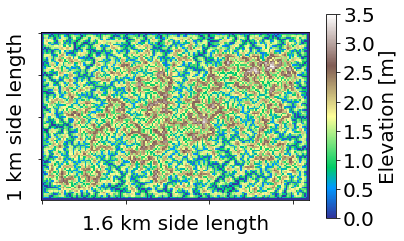

In [11]:
##MAKE TOPO FIGURE
#define 'topo'
topo = st.grid.at_node['topographic__elevation']
#plotting param
matplotlib.rcParams.update({'font.size': 20})

# #instantiate figure and plot
topo_fig = plt.figure(figsize=(6, 3.75))
t1 = plt.subplot()
topo = topo.reshape(100,160)
ts1_plot = t1.imshow(topo[::-1], cmap='terrain', vmin = 0, vmax = 3.5)

#add colorbar
cb = plt.colorbar(ts1_plot, label = 'Elevation [m]')

#axis labels
t1.tick_params(labelbottom='off', labelleft='off') 
t1.set_ylabel('1 km side length', labelpad = 15)
t1.set_xlabel('1.6 km side length', labelpad = 15)

#save figure
topo_fig.savefig('stochastic_vsa_topo.eps',bbox_inches='tight', dpi=300)

In [ ]:
a = st.rain_rate * st.area
print(min(a))
print(max(a))
print(np.mean(a))


In [ ]:
st.grid.at_node['topographic__steepest_slope'][100:200]

In [ ]:
tls = st.tlam*0.005
qss = tls * (1.0 - np.exp(-np.mean(a) / tls))
print(qss)
print((np.mean(a) - qss) / np.mean(a))

In [ ]:
st.tlam